In [1]:
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, applications
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from pathlib import Path


2021-12-08 22:26:08.623709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 22:26:08.623748: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Helpers


In [2]:
def plotHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.plot(epochs, acc, label="Training accuracy")
    plt.plot(epochs, val_acc, label="Validation accuracy")
    plt.legend()
    plt.title('Training and validation accuracy')
    plt.figure()

    plt.plot(epochs, loss, label="Training loss")
    plt.plot(epochs, val_loss, label="Validation loss")
    plt.legend()
    plt.title('Training and validation loss')


In [3]:
checkpoint_path = './checkpoints/lab2/'


def get_cp_callback(path):
    return tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                              save_weights_only=True,
                                              save_freq="epoch",
                                              verbose=1)


def purge_checkpoints():
    if os.path.isdir(checkpoint_path):
        subprocess.run(['rm', '-rf', checkpoint_path])
        subprocess.run(['mkdir', checkpoint_path])


# Data processing


In [4]:
dataset_path = Path(r'./data/lab2')

file_path = list(dataset_path.glob(r'**/*.png'))

# create labels from the folder name
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))


In [5]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']

df.head()


,image,label
0,data/lab2/Shrimp/Shrimp/00047.png,Shrimp
1,data/lab2/Shrimp/Shrimp/00056.png,Shrimp
2,data/lab2/Shrimp/Shrimp/00168.png,Shrimp
3,data/lab2/Shrimp/Shrimp/00657.png,Shrimp
4,data/lab2/Shrimp/Shrimp/00795.png,Shrimp


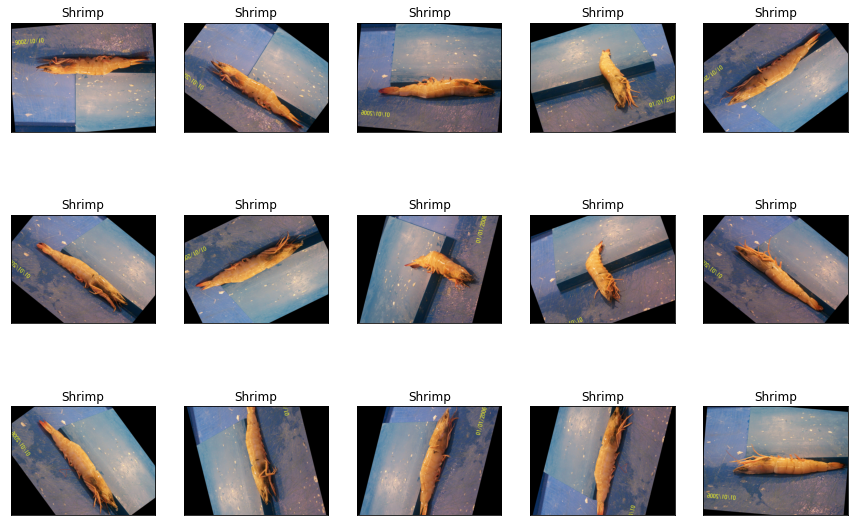

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(
    15, 10), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])

plt.show()


In [7]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Shrimp                1000
Sea Bass              1000
Hourse Mackerel       1000
Red Mullet            1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Trout                 1000
Black Sea Sprat       1000
Red Sea Bream         1000
Name: label, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size=0.2, random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.3, random_state=30)

print("Shape of training data", x_train.shape)
print("Shape of test_ds data", x_test.shape)
print("Shape of validation data", x_val.shape)


Shape of training data (5040, 2)
Shape of test_ds data (1800, 2)
Shape of validation data (2160, 2)


# Initial model

In [9]:
image_data_generator = ImageDataGenerator()

train_ds = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=(200, 200),
                                                    color_mode='rgb',
                                                    class_mode='categorical')

test_ds = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                   x_col='image',
                                                   y_col='label',
                                                   target_size=(200, 200),
                                                   color_mode='rgb',
                                                   class_mode='categorical')

val_ds = image_data_generator.flow_from_dataframe(dataframe=x_val,
                                                  x_col='image',
                                                  y_col='label',
                                                  target_size=(200, 200),
                                                  color_mode='rgb',
                                                  class_mode='categorical')


Found 5040 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.


In [10]:
input_shape = (200, 200, 3)
checkpoint_path = "./checkpoints/lab2/init/"
purge_checkpoints()

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax')
])


2021-12-08 22:26:13.287931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-08 22:26:13.287956: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-08 22:26:13.287974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Arch): /proc/driver/nvidia/version does not exist
2021-12-08 22:26:13.288679: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
158/158 [==============================] - ETA: 0s - loss: 38.3828 - acc: 0.7060
Epoch 00001: saving model to ./checkpoints/lab2/init/
158/158 [==============================] - 159s 995ms/step - loss: 38.3828 - acc: 0.7060 - val_loss: 0.3193 - val_acc: 0.9120
Epoch 2/10
158/158 [==============================] - ETA: 0s - loss: 0.1588 - acc: 0.9540
Epoch 00002: saving model to ./checkpoints/lab2/init/
158/158 [==============================] - 154s 967ms/step - loss: 0.1588 - acc: 0.9540 - val_loss: 0.1449 - val_acc: 0.9574
Epoch 3/10
158/158 [==============================] - ETA: 0s - loss: 0.1108 - acc: 0.9681
Epoch 00003: saving model to ./checkpoints/lab2/init/
158/158 [==============================] - 153s 962ms/step - loss: 0.1108 - acc: 0.9681 - val_loss: 0.0894 - val_acc: 0.9718
Epoch 4/10
158/158 [==============================] - ETA: 0s - loss: 0.0689 - acc: 0.9782
Epoch 00004: saving model to ./checkpoints/lab2/init/
158/158 [==============================] - 

2021-12-08 22:53:13.241552: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/lab2/init/assets


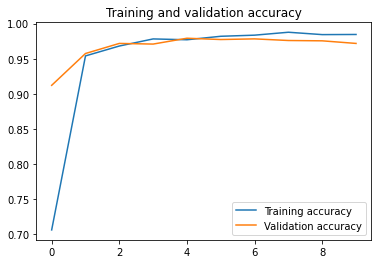

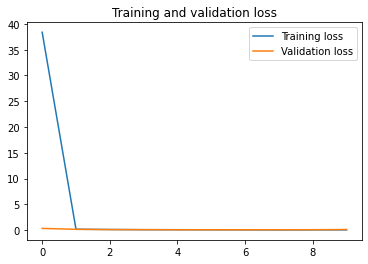

In [11]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["acc"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[get_cp_callback(checkpoint_path)],
                    epochs=10,
                    use_multiprocessing=True,
                    workers=4)

plotHistory(history)
model.save('./models/lab2/init/')


# Augmentation

In [12]:
batch_size = 64

image_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

train_ds = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                 x_col='image',
                                                 y_col='label',
                                                 target_size=(200, 200),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

test_ds = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                x_col='image',
                                                y_col='label',
                                                target_size=(200, 200),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=batch_size)

val_ds = image_data_generator.flow_from_dataframe(dataframe=x_val,
                                               x_col='image',
                                               y_col='label',
                                               target_size=(200, 200),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)


Found 5040 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.


In [13]:
input_shape = (200, 200, 3)
checkpoint_path = "./checkpoints/lab2/augm/"
purge_checkpoints()

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax')
])

# model.summary()


Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 2.4336 - acc: 0.1113
Epoch 00001: saving model to ./checkpoints/lab2/augm/
79/79 [==============================] - 171s 2s/step - loss: 2.4336 - acc: 0.1113 - val_loss: 2.1939 - val_acc: 0.1213
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 2.1869 - acc: 0.1417
Epoch 00002: saving model to ./checkpoints/lab2/augm/
79/79 [==============================] - 170s 2s/step - loss: 2.1869 - acc: 0.1417 - val_loss: 2.1734 - val_acc: 0.1454
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 2.1033 - acc: 0.1873
Epoch 00003: saving model to ./checkpoints/lab2/augm/
79/79 [==============================] - 189s 2s/step - loss: 2.1033 - acc: 0.1873 - val_loss: 1.9898 - val_acc: 0.2315
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 1.8293 - acc: 0.2917
Epoch 00004: saving model to ./checkpoints/lab2/augm/
79/79 [==============================] - 203s 3s/step - loss: 1.8293

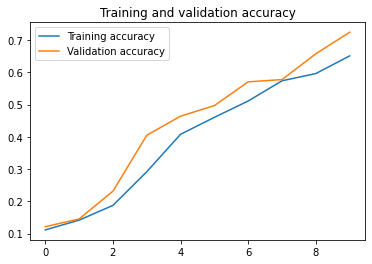

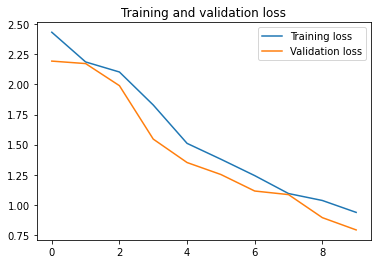

In [14]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["acc"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[get_cp_callback(checkpoint_path)],
                    epochs=10,
                    use_multiprocessing=True,
                    workers=4)

plotHistory(history)
model.save('./models/lab2/augm/')

# 100x100 Image size

In [15]:
batch_size = 64

image_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

train_ds = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                 x_col='image',
                                                 y_col='label',
                                                 target_size=(100, 100),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

test_ds = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                x_col='image',
                                                y_col='label',
                                                target_size=(100, 100),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=batch_size)

val_ds = image_data_generator.flow_from_dataframe(dataframe=x_val,
                                               x_col='image',
                                               y_col='label',
                                               target_size=(100, 100),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

Found 5040 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.


In [16]:
input_shape = (100, 100, 3)
checkpoint_path = "./checkpoints/lab2/100x100/"
purge_checkpoints()

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(9, activation='softmax')
])

# model.summary()

Epoch 1/20
79/79 [==============================] - ETA: 0s - loss: 2.0035 - acc: 0.2413
Epoch 00001: saving model to ./checkpoints/lab2/100x100/
79/79 [==============================] - 159s 2s/step - loss: 2.0035 - acc: 0.2413 - val_loss: 1.7266 - val_acc: 0.3319
Epoch 2/20
79/79 [==============================] - ETA: 0s - loss: 1.6182 - acc: 0.3738
Epoch 00002: saving model to ./checkpoints/lab2/100x100/
79/79 [==============================] - 119s 2s/step - loss: 1.6182 - acc: 0.3738 - val_loss: 1.4493 - val_acc: 0.4491
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 1.4033 - acc: 0.4786
Epoch 00003: saving model to ./checkpoints/lab2/100x100/
79/79 [==============================] - 119s 2s/step - loss: 1.4033 - acc: 0.4786 - val_loss: 1.3079 - val_acc: 0.5255
Epoch 4/20
79/79 [==============================] - ETA: 0s - loss: 1.2197 - acc: 0.5496
Epoch 00004: saving model to ./checkpoints/lab2/100x100/
79/79 [==============================] - 120s 2s/step - 

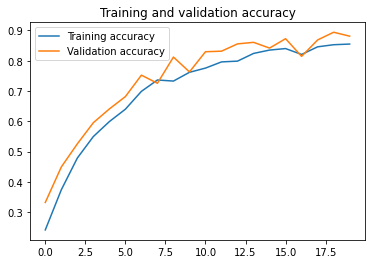

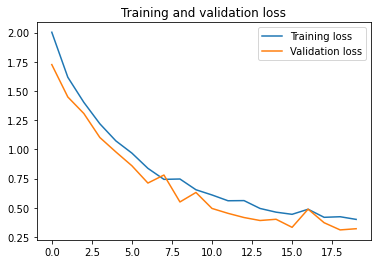

In [17]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["acc"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[
                        get_cp_callback(checkpoint_path)
                        # tf.keras.callbacks.EarlyStopping(
                        #     monitor='val_loss',
                        #     patience=1,
                        #     restore_best_weights=True
                        # )
                    ],
                    epochs=20)

plotHistory(history)
model.save('./models/lab2/100x100/')


# Transfer learning (ResNet)

In [18]:
batch_size = 64

image_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          horizontal_flip=True,
                                          fill_mode='nearest')

train_ds = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                 x_col='image',
                                                 y_col='label',
                                                 target_size=(200, 200),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

test_ds = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                x_col='image',
                                                y_col='label',
                                                target_size=(200, 200),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=batch_size)

val_ds = image_data_generator.flow_from_dataframe(dataframe=x_val,
                                               x_col='image',
                                               y_col='label',
                                               target_size=(200, 200),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

Found 5040 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.


In [19]:
input_shape = (200, 200, 3)
checkpoint_path = "./checkpoints/lab2/resn/"
purge_checkpoints()

base_model = applications.ResNet50V2(include_top=False,
                                      input_shape=input_shape)
base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation="relu")(x)
output_layer = layers.Dense(9, activation='softmax')(x)

model = models.Model(inputs=base_model.inputs,
                     outputs=output_layer)



94683136/94668760 [==============================] - 9s 0us/step


Epoch 1/10
79/79 [==============================] - ETA: 0s - loss: 6.9370 - acc: 0.5827
Epoch 00001: saving model to ./checkpoints/lab2/resn/
79/79 [==============================] - 340s 4s/step - loss: 6.9370 - acc: 0.5827 - val_loss: 0.8754 - val_acc: 0.7694
Epoch 2/10
79/79 [==============================] - ETA: 0s - loss: 0.6821 - acc: 0.8335
Epoch 00002: saving model to ./checkpoints/lab2/resn/
79/79 [==============================] - 322s 4s/step - loss: 0.6821 - acc: 0.8335 - val_loss: 0.7022 - val_acc: 0.8468
Epoch 3/10
79/79 [==============================] - ETA: 0s - loss: 0.4699 - acc: 0.8837
Epoch 00003: saving model to ./checkpoints/lab2/resn/
79/79 [==============================] - 287s 4s/step - loss: 0.4699 - acc: 0.8837 - val_loss: 0.4236 - val_acc: 0.8991
Epoch 4/10
79/79 [==============================] - ETA: 0s - loss: 0.3459 - acc: 0.9018
Epoch 00004: saving model to ./checkpoints/lab2/resn/
79/79 [==============================] - 289s 4s/step - loss: 0.3459

/home/pacifi5t/Projects/University/neural-networks/.venv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/pacifi5t/Projects/University/neural-networks/.venv/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


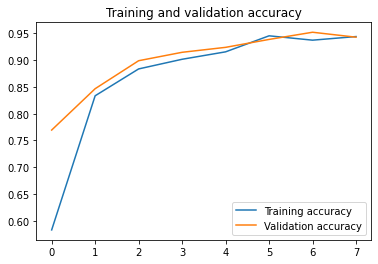

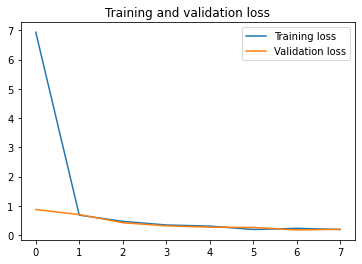

In [20]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["acc"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[
                        get_cp_callback(checkpoint_path),
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=1,
                            restore_best_weights=True
                        )
                    ],
                    epochs=10)

plotHistory(history)
model.save('./models/lab2/resn/')


# Transfer learning (MobileNet)

In [21]:
batch_size = 64

image_data_generator = ImageDataGenerator()

train_ds = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=(200, 200),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

test_ds = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                   x_col='image',
                                                   y_col='label',
                                                   target_size=(200, 200),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=batch_size)

val_ds = image_data_generator.flow_from_dataframe(dataframe=x_val,
                                                  x_col='image',
                                                  y_col='label',
                                                  target_size=(200, 200),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  batch_size=batch_size)


Found 5040 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 2160 validated image filenames belonging to 9 classes.


In [22]:
input_shape = (200, 200, 3)
checkpoint_path = "./checkpoints/lab2/mobn/"
purge_checkpoints()

base_model = applications.MobileNetV2(include_top=False,
                                      input_shape=input_shape)
base_model.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(128, activation="relu")(x)
output_layer = layers.Dense(9, activation='softmax')(x)

model = models.Model(inputs=base_model.inputs,
                     outputs=output_layer)


Epoch 1/5
79/79 [==============================] - ETA: 0s - loss: 3.8579 - acc: 0.6107
Epoch 00001: saving model to ./checkpoints/lab2/mobn/
79/79 [==============================] - 150s 2s/step - loss: 3.8579 - acc: 0.6107 - val_loss: 0.5994 - val_acc: 0.7954
Epoch 2/5
79/79 [==============================] - ETA: 0s - loss: 0.1947 - acc: 0.9393
Epoch 00002: saving model to ./checkpoints/lab2/mobn/
79/79 [==============================] - 138s 2s/step - loss: 0.1947 - acc: 0.9393 - val_loss: 0.2460 - val_acc: 0.9204
Epoch 3/5
79/79 [==============================] - ETA: 0s - loss: 0.0668 - acc: 0.9901
Epoch 00003: saving model to ./checkpoints/lab2/mobn/
79/79 [==============================] - 188s 2s/step - loss: 0.0668 - acc: 0.9901 - val_loss: 0.2096 - val_acc: 0.9315
Epoch 4/5
79/79 [==============================] - ETA: 0s - loss: 0.0334 - acc: 0.9986
Epoch 00004: saving model to ./checkpoints/lab2/mobn/
79/79 [==============================] - 122s 2s/step - loss: 0.0334 - a

/home/pacifi5t/Projects/University/neural-networks/.venv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/pacifi5t/Projects/University/neural-networks/.venv/lib/python3.9/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


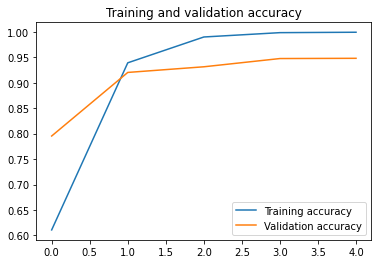

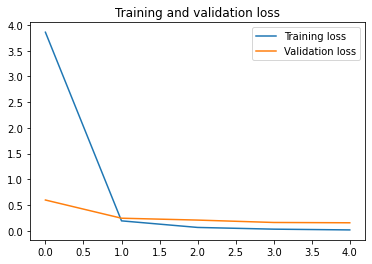

In [23]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["acc"])

history = model.fit(train_ds,
                    validation_data=val_ds,
                    callbacks=[get_cp_callback(checkpoint_path)],
                    epochs=5)

plotHistory(history)
model.save('./models/lab2/mobn/')